In [ ]:
def score_data(input_folder, output_folder, model_path, exp_config, do_postprocessing=False, gt_exists=True, evaluate_all=False, use_iter=None):

        for folder in os.listdir(input_folder):

            folder_path = os.path.join(input_folder, folder)

            if os.path.isdir(folder_path):

                if evaluate_test_set or evaluate_all:
                    train_test = 'test'  # always test
                else:
                    train_test = 'test' if (int(folder[-3:]) % 5 == 0) else 'train'


                if train_test == 'test':

                    infos = {}
                    for line in open(os.path.join(folder_path, 'Info.cfg')):
                        label, value = line.split(':')
                        infos[label] = value.rstrip('\n').lstrip(' ')

                    patient_id = folder.lstrip('patient')
                    ED_frame = int(infos['ED'])
                    ES_frame = int(infos['ES'])

                    for file in glob.glob(os.path.join(folder_path, 'patient???_frame??.nii.gz')):

                        file_base = file.split('.nii.gz')[0]

                        frame = int(file_base.split('frame')[-1])
                        img_dat = utils.load_nii(file)
                        img = img_dat[0].copy()
                        img = image_utils.normalise_image(img)

                        if gt_exists:
                            file_mask = file_base + '_gt.nii.gz'
                            mask_dat = utils.load_nii(file_mask)
                            mask = mask_dat[0]
##################
                        start_time = time.time()

                        pixel_size = (img_dat[2].structarr['pixdim'][1], img_dat[2].structarr['pixdim'][2])
                        scale_vector = (pixel_size[0] / exp_config.target_resolution[0],
                                        pixel_size[1] / exp_config.target_resolution[1])

                        predictions = []

                        for zz in range(img.shape[2]):

                            slice_img = np.squeeze(img[:,:,zz])
                            slice_rescaled = transform.rescale(slice_img,
                                                            scale_vector,
                                                            order=1,
                                                            preserve_range=True,
                                                            multichannel=False,
                                                            anti_aliasing=True,
                                                            mode='constant')

                            x, y = slice_rescaled.shape

                            x_s = (x - nx) // 2
                            y_s = (y - ny) // 2
                            x_c = (nx - x) // 2
                            y_c = (ny - y) // 2

                            # Crop section of image for prediction
                            if x > nx and y > ny:
                                slice_cropped = slice_rescaled[x_s:x_s+nx, y_s:y_s+ny]
                            else:
                                slice_cropped = np.zeros((nx,ny))
                                if x <= nx and y > ny:
                                    slice_cropped[x_c:x_c+ x, :] = slice_rescaled[:,y_s:y_s + ny]
                                elif x > nx and y <= ny:
                                    slice_cropped[:, y_c:y_c + y] = slice_rescaled[x_s:x_s + nx, :]
                                else:
                                    slice_cropped[x_c:x_c+x, y_c:y_c + y] = slice_rescaled[:, :]


                            # GET PREDICTION
                            network_input = np.float32(np.tile(np.reshape(slice_cropped, (nx, ny, 1)), (batch_size, 1, 1, 1)))
                            mask_out, logits_out = sess.run([mask_pl, softmax_pl], feed_dict={images_pl: network_input})
                            prediction_cropped = np.squeeze(logits_out[0,...])

                            # ASSEMBLE BACK THE SLICES
                            slice_predictions = np.zeros((x,y,num_channels))
                            # insert cropped region into original image again
                            if x > nx and y > ny:
                                slice_predictions[x_s:x_s+nx, y_s:y_s+ny,:] = prediction_cropped
                            else:
                                if x <= nx and y > ny:
                                    slice_predictions[:, y_s:y_s+ny,:] = prediction_cropped[x_c:x_c+ x, :,:]
                                elif x > nx and y <= ny:
                                    slice_predictions[x_s:x_s + nx, :,:] = prediction_cropped[:, y_c:y_c + y,:]
                                else:
                                    slice_predictions[:, :,:] = prediction_cropped[x_c:x_c+ x, y_c:y_c + y,:]

                            # RESCALING ON THE LOGITS
                            if gt_exists:
                                prediction = transform.resize(slice_predictions,
                                                              (mask.shape[0], mask.shape[1], num_channels),
                                                              order=1,
                                                              preserve_range=True,
                                                              anti_aliasing=True,
                                                              mode='constant')
                            else:  # This can occasionally lead to wrong volume size, therefore if gt_exists
                                   # we use the gt mask size for resizing.
                                prediction = transform.rescale(slice_predictions,
                                                               (1.0/scale_vector[0], 1.0/scale_vector[1], 1),
                                                               order=1,
                                                               preserve_range=True,
                                                               multichannel=False,
                                                               anti_aliasing=True,
                                                               mode='constant')

                            # prediction = transform.resize(slice_predictions,
                            #                               (mask.shape[0], mask.shape[1], num_channels),
                            #                               order=1,
                            #                               preserve_range=True,
                            #                               mode='constant')

                            prediction = np.uint8(np.argmax(prediction, axis=-1))
                            predictions.append(prediction)


                        prediction_arr = np.transpose(np.asarray(predictions, dtype=np.uint8), (1,2,0))

                        # This is the same for 2D and 3D again
                        if do_postprocessing:
                            prediction_arr = image_utils.keep_largest_connected_components(prediction_arr)

                        elapsed_time = time.time() - start_time
                        total_time += elapsed_time
                        total_volumes += 1

                        logging.info('Evaluation of volume took %f secs.' % elapsed_time)

                        if frame == ED_frame:
                            frame_suffix = '_ED'
                        elif frame == ES_frame:
                            frame_suffix = '_ES'
                        else:
                            raise ValueError('Frame doesnt correspond to ED or ES. frame = %d, ED = %d, ES = %d' %
                                             (frame, ED_frame, ES_frame))

                        # Save prediced mask
                        out_file_name = os.path.join(output_folder, 'prediction',
                                                     'patient' + patient_id + frame_suffix + '.nii.gz')
                        if gt_exists:
                            out_affine = mask_dat[1]
                            out_header = mask_dat[2]
                        else:
                            out_affine = img_dat[1]
                            out_header = img_dat[2]

                        logging.info('saving to: %s' % out_file_name)
                        utils.save_nii(out_file_name, prediction_arr, out_affine, out_header)

                        # Save image data to the same folder for convenience
                        image_file_name = os.path.join(output_folder, 'image',
                                                'patient' + patient_id + frame_suffix + '.nii.gz')
                        logging.info('saving to: %s' % image_file_name)
                        utils.save_nii(image_file_name, img_dat[0], out_affine, out_header)

                        if gt_exists:

                            # Save GT image
                            gt_file_name = os.path.join(output_folder, 'ground_truth', 'patient' + patient_id + frame_suffix + '.nii.gz')
                            logging.info('saving to: %s' % gt_file_name)
                            utils.save_nii(gt_file_name, mask, out_affine, out_header)

                            # Save difference mask between predictions and ground truth
                            difference_mask = np.where(np.abs(prediction_arr-mask) > 0, [1], [0])
                            difference_mask = np.asarray(difference_mask, dtype=np.uint8)
                            diff_file_name = os.path.join(output_folder,
                                                          'difference',
                                                          'patient' + patient_id + frame_suffix + '.nii.gz')
                            logging.info('saving to: %s' % diff_file_name)
                            utils.save_nii(diff_file_name, difference_mask, out_affine, out_header)


        logging.info('Average time per volume: %f' % (total_time/total_volumes))

    return init_iteration



In [ ]:
def get_patients(input_folder='/home/adri/Studies/PhD_UCD/mri-example-data/training/'):
    """ This function reads the folder with the patient data and extracts 
        frames and patient info into a dictionary
        
        Args: input_folder - folder with data where patients data are stored
        
        Returns: 
            folders - list with names of frames for patients
            infos - list with dictionaries with information about the patients        
    """
    
    folders = []
    infos = []    
    for folder in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder)
        if os.path.isdir(folder_path):
            folders.append(folder_path)
            info = {}
            for line in open(os.path.join(folder_path, 'Info.cfg')):
                label, value = line.split(':')
                info[label] = value.rstrip('\n').lstrip(' ')
                if 'ED' in info: info['ED'] = int(info['ED'])
                if 'ES' in info: info['ES'] = int(info['ES'])
            infos.append(info)

    return folders, infos

def get_frame_number(file_base):
    """Given file name extracts the number of encoded there frame 
       (that designates the phase of the heart cycle - end-diastole, 
       end-systole)"""
    return int(file_base.split('frame')[-1])

In [14]:
import json

In [21]:
cf = json.loads('params.json')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [22]:
with open('params.json') as f:
    cf = json.loads(f.read())

In [23]:
cf

{'BATCH_SIZE': 10,
 'INPUT_PATCH_SIZE': 348,
 'num_classes': 4,
 'EXPERIMENT_NAME': 'Test-Implementation',
 'results_dir': './results-experiment',
 'n_epochs': 300,
 'lr_decay': 0.985,
 'base_lr': 0.0005,
 'n_batches_per_epoch': 10,
 'n_test_batches': 10,
 'n_feedbacks_per_epoch': 10,
 'num_workers': 6,
 'workers_seeds': [123, 1234, 12345, 123456, 1234567, 12345678],
 'weight_decay': 1e-05,
 'n_input_channels': 1}

In [27]:
import numpy as np
x = np.array([[1,2,0],[0,1,1],[1,1,2]])
x

array([[1, 2, 0],
       [0, 1, 1],
       [1, 1, 2]])

In [28]:
y = np.array([[1,0,0],[0,1,1],[1,2,2]])
y

array([[1, 0, 0],
       [0, 1, 1],
       [1, 2, 2]])

In [29]:
def array_to_hot(arr):
    print(arr)
    size = np.shape(arr)
    unique = set(arr.flatten().tolist())
    tab = []
    for elem in unique:
        tmp = np.zeros(size)        
        inds = np.argwhere(arr==elem)
        for ind in inds:
            tmp[ind[0]][ind[1]] = 1.
        tab.append(tmp)
    return np.stack(tab)

In [42]:
y_pred = np.argmax(x)

In [43]:
y_pred

1

In [30]:
X = array_to_hot(x)

[[1 2 0]
 [0 1 1]
 [1 1 2]]


In [31]:
X

array([[[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 1.],
        [1., 1., 0.]],

       [[0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 1.]]])

In [32]:
Y = array_to_hot(y)

[[1 0 0]
 [0 1 1]
 [1 2 2]]


In [33]:
Y

array([[[0., 1., 1.],
        [1., 0., 0.],
        [0., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 1.],
        [1., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 1.]]])

In [34]:
Y*X

array([[[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 1.],
        [1., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.]]])

In [35]:
intersection = (Y*X).sum()

In [36]:
intersection

7.0

In [37]:
smooth = 1
up = (2. * intersection + smooth) 

In [38]:
down = (Y.sum() + X.sum() + smooth)

In [39]:
dice = up/down
dice

0.7894736842105263

/home/adri/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/home/adri/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


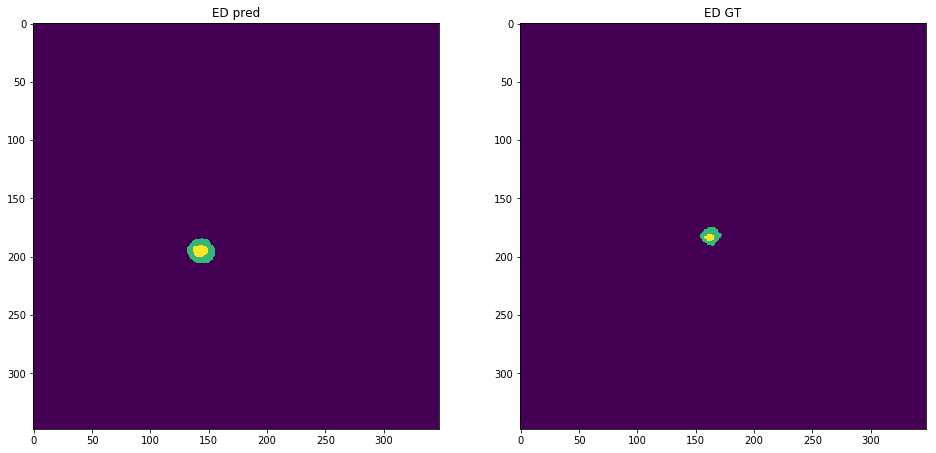

0.0007331378299120235


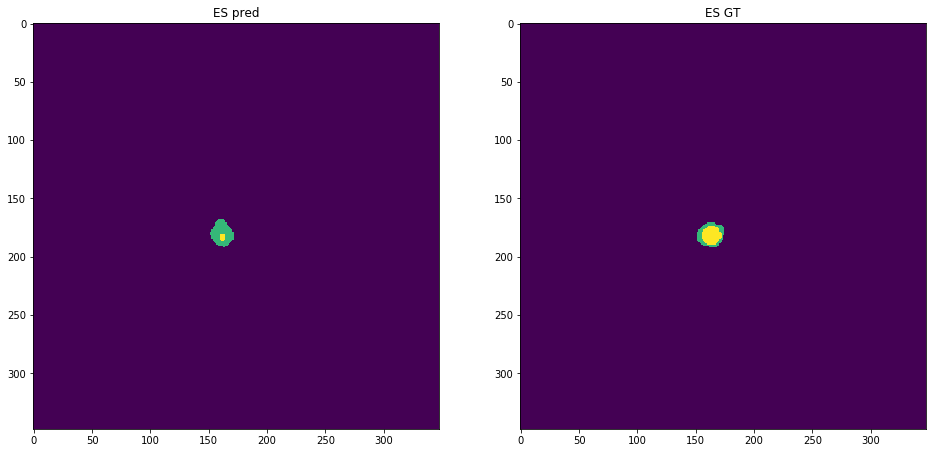

2.0303030303030303


In [51]:
import nibabel as nib
import matplotlib.pyplot as plt

def dice(data_p, data_t):
    intersection = (data_p * data_t).sum()
    smooth = 1
    dice = (2. * intersection + smooth) / (data_p.sum() + data_t.sum() + smooth)
    print(dice)

for frame in ['ED','ES']:
    patient = 51
    patient = str(patient)

    plt.figure(figsize=(16,10))
    img = nib.load('submission/pred/patient'+patient+'_'+frame+'.nii.gz')
    data_p = img.get_data()
    plt.subplot(1,2,1)
    plt.imshow(data_p)
    plt.title(frame + " pred")    

    img = nib.load('submission/gt/patient'+patient+'_'+frame+'.nii.gz')
    plt.subplot(1,2,2)
    data_t = img.get_data()
    plt.imshow(data_t)
    plt.title(frame + " GT")
    plt.show()
    import numpy as np
    dice(data_p, data_t)    

In [57]:
set(data_t.flatten().tolist())

{0.0, 2.0, 3.0}

In [96]:
from collections import Counter
Counter(data_p.flatten())

Counter({0.0: 120772, 2.0: 304, 3.0: 28})

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(22,10))
axs[0].imshow(Y_hat[0])
axs[0].title.set_text('Prediction')
axs[0].axis('off')
axs[1].imshow(Y[0].reshape(348,348)[92:-92,92:-92])
axs[1].title.set_text('Ground Truth')
axs[1].axis('off')
axs[2].imshow(X[0].reshape(348,348)[92:-92,92:-92])
axs[2].title.set_text('Original Image')
axs[2].axis('off')
plt.show()

In [47]:
arr = [0.40957337617874146, 0.4095686376094818, 0.46964988112449646, 0.44718894362449646, 0.49015769362449646, 0.44523581862449646, 0.46183738112449646, 0.3783044219017029, 0.43644675612449646, 0.49894675612449646, 0.32511863112449646, 0.46769675612449646, 0.44079020619392395, 0.40953072905540466, 0.472025990486145, 0.503275990486145, 0.40948808193206787, 0.5032286047935486, 0.4094786047935486, 0.5657286047935486, 0.5031906962394714, 0.5656717419624329, 0.4719170033931732, 0.4999185800552368, 0.4217935800552368, 0.5780435800552368, 0.5008951425552368, 0.4852701425552368, 0.5643717050552368, 0.4100748300552368, 0.5038248300552368, 0.4725748300552368, 0.5506998300552368, 0.5031527876853943, 0.5344027876853943, 0.253143310546875, 0.47187909483909607, 0.5031243562698364, 0.5656148791313171, 0.4405864477157593, 0.44058170914649963, 0.5968174934387207, 0.47181275486946106, 0.40931275486946106, 0.4405580163002014, 0.47179853916168213, 0.40929853916168213, 0.37803906202316284, 0.5030390620231628, 0.4092843234539032, 0.3456169664859772, 0.3797966539859772, 0.4891716539859772, 0.4120232164859772, 0.4432732164859772, 0.4559685289859772, 0.3827263414859772, 0.4618279039859772, 0.4481560289859772, 0.4012810289859772, 0.5654916763305664, 0.3467321991920471, 0.5029632449150085, 0.34671324491500854, 0.40921324491500854, 0.47167059779167175, 0.4716326892375946, 0.565377950668335, 0.5653684735298157, 0.46865910291671753, 0.5643622279167175, 0.5497137904167175, 0.5809637904167175, 0.5506903529167175, 0.48819035291671753, 0.45694035291671753, 0.5829169154167175, 0.5682684779167175, 0.47451847791671753, 0.4403589963912964, 0.5340995192527771, 0.40907108783721924, 0.5028116106987, 0.4715568721294403, 0.40905213356018066, 0.44030213356018066, 0.5027926564216614, 0.3152926564216614, 0.5027831792831421, 0.5027737021446228, 0.5652737021446228, 0.5340237021446228, 0.47151896357536316, 0.3777642250061035, 0.5027547478675842, 0.5652547478675842, 0.5339763164520264, 0.5027168393135071, 0.4374043643474579, 0.4393574893474579, 0.4110371768474579, 0.4305684268474579, 0.4012715518474579, 0.4247090518474579, 0.4334981143474579, 0.4120137393474579, 0.3768574893474579, 0.4401978850364685, 0.5026978850364685, 0.5651694536209106, 0.5026694536209106, 0.4714052379131317, 0.5964004993438721, 0.5338910222053528, 0.5963815450668335, 0.44011732935905457, 0.440098375082016, 0.5025936365127563, 0.5963152050971985, 0.5165011882781982, 0.5008761882781982, 0.48720431327819824, 0.5184543132781982, 0.40907931327819824, 0.42568087577819824, 0.41005587577819824, 0.44228243827819824, 0.48915743827819824, 0.45790743827819824, 0.47129151225090027, 0.3462867736816406, 0.3775225579738617, 0.3462725579738617, 0.4087630808353424, 0.5337583422660828, 0.6274988651275635, 0.3774799108505249, 0.5337299108505249, 0.5649704337120056, 0.40868252515792847, 0.43993252515792847, 0.5649230480194092, 0.3774230480194092, 0.47116830945014954, 0.5024135708808899, 0.4086635708808899, 0.4569261372089386, 0.4979417622089386, 0.4461839497089386, 0.4871995747089386, 0.4637620747089386, 0.4276292622089386, 0.4666917622089386, 0.4959886372089386, 0.4442308247089386, 0.4911058247089386, 0.3461540937423706, 0.5023661851882935, 0.5336067080497742, 0.47110670804977417, 0.5648567080497742, 0.5023567080497742, 0.4398472309112549, 0.4710972309112549, 0.3460877537727356, 0.377318799495697, 0.43980932235717773, 0.3773045837879181, 0.47104984521865845, 0.40854984521865845, 0.5647903680801392, 0.3772856295108795, 0.5335119366645813, 0.43975719809532166, 0.46864014863967896, 0.609265148639679, 0.516491711139679, 0.30067139863967896, 0.37977296113967896, 0.567272961139679, 0.42664796113967896, 0.505749523639679, 0.568249523639679, 0.37489014863967896, 0.408502459526062, 0.47098350524902344, 0.43974772095680237, 0.43972402811050415, 0.4397050738334656, 0.43970033526420593, 0.4084455966949463, 0.43969085812568665, 0.439686119556427, 0.37718138098716736, 0.5334266424179077, 0.4084266424179077, 0.5959171652793884, 0.5334076881408691, 0.4396339952945709, 0.377119779586792, 0.4383619725704193, 0.4500807225704193, 0.4276197850704193, 0.4451979100704193, 0.3914869725704193, 0.2948072850704193, 0.4432447850704193, 0.3992994725704193, 0.5333413481712341, 0.4285963475704193, 0.5333318710327148, 0.4083271324634552, 0.47083187103271484, 0.5645913481712341, 0.5958413481712341, 0.4083176553249359, 0.5645629167556763, 0.34579870104789734, 0.5332939624786377, 0.4082844853401184, 0.5645344853401184, 0.5645250082015991, 0.5332750082015991, 0.5332655310630798, 0.5020155310630798, 0.5957276225090027, 0.5019681453704834, 0.5369900465011597, 0.5330837965011597, 0.5965603590011597, 0.42566192150115967, 0.5975369215011597, 0.5076931715011597, 0.41394317150115967, 0.43054473400115967, 0.46277129650115967, 0.5721462965011597, 0.5644397139549255, 0.31443023681640625, 0.4081849753856659, 0.5019302368164062, 0.6269018054008484, 0.4393828511238098, 0.6268733739852905, 0.43936389684677124, 0.40811389684677124, 0.4393591582775116, 0.43934494256973267, 0.4393354654312134, 0.5018259882926941, 0.43932124972343445, 0.4393165111541748, 0.2518165111541748, 0.4393070340156555, 0.4705570340156555, 0.4344462454319, 0.4656962454319, 0.4813212454319, 0.4754618704319, 0.4539774954319, 0.4383524954319, 0.4578837454319, 0.5642975568771362, 0.4666728079319, 0.4608134329319, 0.43929755687713623, 0.4080333411693573, 0.37676912546157837, 0.40801912546157837, 0.5017596483230591, 0.4079906940460205, 0.5642312169075012, 0.5017217397689819, 0.43920278549194336, 0.5329527854919434, 0.4079480469226837, 0.4704433083534241, 0.4391933083534241, 0.34543856978416443, 0.31417909264564514, 0.40792909264564514, 0.47041961550712585, 0.4217461943626404, 0.4373711943626404, 0.5008477568626404, 0.4715508818626404, 0.4598321318626404, 0.6287774443626404, 0.5369805693626404, 0.5418633818626404, 0.4666680693626404, 0.5379571318626404, 0.4391317069530487, 0.4391222298145294, 0.314141184091568, 0.5016269683837891, 0.4078674912452698, 0.3765795826911926, 0.43907010555267334, 0.3453153669834137, 0.4390464127063751, 0.4702821969985962, 0.5015321969985962, 0.40776798129081726, 0.4077632427215576, 0.5015037655830383, 0.40611645579338074, 0.42369458079338074, 0.37681958079338074, 0.42760083079338074, 0.41392895579338074, 0.47740551829338074, 0.49400708079338074, 0.41685864329338074, 0.45592114329338074, 0.43897533416748047, 0.19884110987186432, 0.4389469027519226, 0.4701969027519226, 0.5014469027519226, 0.5014374256134033, 0.4076874256134033, 0.4389374256134033, 0.595177948474884, 0.5014184713363647, 0.43891847133636475, 0.5951684713363647, 0.5326684713363647, 0.43890899419784546, 0.5639089941978455, 0.5639184713363647, 0.5326495170593262, 0.5951400399208069, 0.40763530135154724, 0.47013530135154724, 0.5638710856437683, 0.4388710856437683, 0.5164632797241211, 0.4412679672241211, 0.5516195297241211, 0.3797445297241211, 0.4119710922241211, 0.5682210922241211, 0.3807210922241211, 0.5057210922241211, 0.4373617172241211, 0.4529867172241211, 0.47009265422821045, 0.37633317708969116, 0.4388142228126526, 0.438795268535614, 0.3762715756893158, 0.3762620985507965, 0.4387052357196808, 0.5012004971504211, 0.6574504971504211, 0.46995049715042114, 0.43931010365486145, 0.41001322865486145, 0.39536479115486145, 0.38462260365486145, 0.39243510365486145, 0.37973979115486145, 0.32505229115486145, 0.38657572865486145, 0.45395854115486145, 0.46993154287338257, 0.40743154287338257, 0.4699220657348633, 0.407412588596344, 0.4386531114578247, 0.5948936343193054, 0.5011436343193054, 0.5636436343193054, 0.46988415718078613, 0.3448794186115265, 0.46987468004226685, 0.40737468004226685, 0.5636246800422668, 0.5323746800422668, 0.43860572576522827, 0.501096248626709, 0.43859151005744934, 0.2510867714881897, 0.5635867714881897, 0.5948272943496704, 0.5323272943496704, 0.4073272943496704, 0.5936022400856018, 0.5164538025856018, 0.4852038025856018, 0.4539538025856018, 0.5506334900856018, 0.5037584900856018, 0.4881334900856018, 0.5662584900856018, 0.5516100525856018, 0.5213366150856018, 0.5947893857955933, 0.4697846472263336, 0.40726569294929504, 0.5322609543800354, 0.3134920001029968, 0.3447420001029968, 0.31346356868743896, 0.37593987584114075, 0.5634351372718811, 0.3759256601333618, 0.3134256601333618, 0.500897228717804, 0.42367562651634216, 0.47152718901634216, 0.39437875151634216, 0.48812875151634216, 0.42660531401634216, 0.41488656401634216, 0.43832406401634216, 0.49496468901634216, 0.37875375151634216, 0.45687875151634216, 0.46961405873298645, 0.40710458159446716, 0.4383498430252075, 0.5320998430252075, 0.500830888748169, 0.43833088874816895, 0.5633214116096497, 0.5945619344711304, 0.5320429801940918, 0.34453824162483215, 0.5007740259170532, 0.4382740259170532, 0.5632645487785339, 0.43824559450149536, 0.5623427629470825, 0.5310927629470825, 0.4529677629470825, 0.5935927629470825, 0.4851943254470825, 0.5789443254470825, 0.4695693254470825, 0.4236708879470825, 0.5183974504470825, 0.5818740129470825, 0.5319576859474182, 0.34443873167037964, 0.40691977739334106, 0.3756650388240814, 0.4694103002548218, 0.43814608454704285, 0.4068913459777832, 0.4693913459777832, 0.5006223917007446, 0.4068392217159271, 0.3299161493778229, 0.4080411493778229, 0.4256192743778229, 0.4373380243778229, 0.4012052118778229, 0.4090177118778229, 0.4168302118778229, 0.4822598993778229, 0.4666348993778229, 0.4265958368778229, 0.5318344831466675, 0.5943250060081482, 0.5005465745925903, 0.5630181431770325, 0.43801814317703247, 0.5317586660385132, 0.4379991888999939, 0.6254991888999939, 0.6254897117614746, 0.4692302346229553, 0.5942018032073975, 0.5310832858085632, 0.45295828580856323, 0.46955984830856323, 0.5476848483085632, 0.43928641080856323, 0.5183879733085632, 0.5027629733085632, 0.5525676608085632, 0.5994426608085632, 0.42952078580856323, 0.4379233717918396, 0.4691638946533203, 0.34416863322257996, 0.500404417514801, 0.531654417514801, 0.40664494037628174, 0.46914494037628174, 0.4691402018070221, 0.43789494037628174, 0.5316354632377625, 0.4691307246685028, 0.4378807246685028, 0.6566259860992432, 0.5628665089607239, 0.5315691232681274, 0.3753143846988678, 0.37528595328330994, 0.3445551097393036, 0.3924066722393036, 0.3621332347393036, 0.4881097972393036, 0.4109613597393036, 0.4744379222393036, 0.4217035472393036, 0.4148676097393036, 0.4314691722393036, 0.3440312147140503, 0.500271737575531, 0.34402647614479065, 0.34400278329849243, 0.4689980447292328, 0.437705397605896, 0.4376864433288574, 0.5001864433288574, 0.4064127504825592, 0.500139057636261, 0.40638431906700134, 0.42169880867004395, 0.593573808670044, 0.40705037117004395, 0.45490193367004395, 0.40900349617004395, 0.565253496170044, 0.48712849617004395, 0.45685505867004395, 0.550605058670044, 0.597480058670044, 0.4376295804977417, 0.46885114908218384, 0.3750869333744049, 0.46883219480514526, 0.43758219480514526, 0.5938321948051453, 0.6250821948051453, 0.406322717666626, 0.531322717666626, 0.37508219480514526, 0.34383219480514526, 0.5625632405281067, 0.4063132405281067, 0.4375632405281067, 0.40628954768180847, 0.4062374234199524, 0.3757956326007843, 0.4265768826007843, 0.4558737576007843, 0.4588034451007843, 0.4441550076007843, 0.4129050076007843, 0.4607565701007843, 0.4138815701007843, 0.4656393826007843, 0.37495899200439453, 0.49995899200439453, 0.34369003772735596, 0.437425822019577, 0.5936331748962402, 0.37487369775772095, 0.5623642206192017, 0.5311142206192017, 0.43736422061920166, 0.4686047434806824, 0.4373357892036438, 0.5310857892036438, 0.40608105063438416, 0.49981433153152466, 0.46856433153152466, 0.5466893315315247, 0.45586901903152466, 0.39532214403152466, 0.42657214403152466, 0.47442370653152466, 0.43731433153152466, 0.39922839403152466, 0.38457995653152466, 0.5935668349266052, 0.37479788064956665, 0.40603840351104736, 0.3435194492340088, 0.4060099720954895, 0.3747599720954895, 0.43725523352622986, 0.4684910178184509, 0.46848154067993164, 0.43721258640289307, 0.40596258640289307, 0.34346258640289307, 0.5934531092643738, 0.40593889355659485, 0.49967941641807556, 0.407036155462265, 0.452934592962265, 0.490043967962265, 0.445122092962265, 0.391411155462265, 0.311333030462265, 0.389458030462265, 0.467583030462265, 0.398247092962265, 0.4371699392795563, 0.5308962464332581, 0.5308772921562195, 0.43707042932510376, 0.4058014750480652, 0.5308014750480652, 0.4370514750480652, 0.34327778220176697, 0.40800797939300537, 0.5662111043930054, 0.5818361043930054, 0.5349611043930054, 0.44121110439300537, 0.5359376668930054, 0.5984376668930054, 0.41093766689300537, 0.44316422939300537, 0.35234391689300537, 0.530763566493988, 0.40573039650917053, 0.4682161808013916, 0.46821144223213196, 0.49942827224731445, 0.3431735336780548, 0.4681593179702759, 0.5619093179702759, 0.4368998408317566, 0.46814510226249695, 0.499380886554718, 0.4382766783237457, 0.4568313658237457, 0.4255813658237457, 0.4109329283237457, 0.4529251158237457, 0.3933548033237457, 0.4499954283237457, 0.46811193227767944, 0.4929641783237457, 0.4617141783237457, 0.4681071937084198, 0.5306024551391602, 0.40559297800064087, 0.4055882394313812, 0.37432876229286194, 0.46807876229286194, 0.468064546585083, 0.4055550694465637, 0.5618050694465637, 0.4368003308773041, 0.46802663803100586, 0.342998206615448, 0.5496000647544861, 0.5203031897544861, 0.4587797522544861, 0.5837797522544861, 0.5329985022544861, 0.4158110022544861, 0.5017485022544861, 0.4167875647544861, 0.4412016272544861, 0.4578031897544861, 0.40545082092285156, 0.5616913437843323, 0.5929413437843323, 0.43668660521507263, 0.37418660521507263, 0.592931866645813, 0.436681866645813, 0.3741723895072937, 0.4991723895072937, 0.43664395809173584, 0.31163448095321655, 0.5303750038146973, 0.5303560495376587, 0.5928370952606201, 0.4990823566913605, 0.5928276181221008, 0.39041563868522644, 0.45291563868522644, 0.37479063868522644, 0.49979063868522644, 0.42361876368522644, 0.43924376368522644, 0.47244688868522644, 0.34744688868522644, 0.39432188868522644, 0.44119688868522644, 0.4365539252758026, 0.4548507034778595, 0.2840438187122345, 0.4149642288684845, 0.4951033890247345, 0.4868026077747345, 0.4340682327747345, 0.4633651077747345, 0.4384627640247345, 0.4545760452747345, 0.4086776077747345, 0.46778497099876404, 0.4677707552909851, 0.31153497099876404, 0.5302612781524658, 0.5927612781524658, 0.4677565395832062, 0.5615018010139465, 0.5927518010139465, 0.530232846736908, 0.5927233695983887, 0.4989638924598694]